# LHC collimation example

In [1]:
import numpy as np
from pathlib import Path

import xobjects as xo
import xtrack as xt
import xcoll as xc

### Import a line

In [2]:
line = xt.Line.from_json('lhc_run3_b1.json')

Loading line from dict:   0%|          | 0/102795 [00:00<?, ?it/s]

Done loading line from dict.           


### Install and configure collimators using `xcoll`

In [3]:
colldb = xc.CollimatorDatabase.from_yaml('collimators_simplified.yaml', beam='1')
colldb.install_everest_collimators(line=line, verbose=True)

Installing tcsg.5l3.b1          as EverestCollimator
Installing tctph.4l1.b1         as EverestCollimator
Installing tcp.d6l7.b1          as EverestCollimator
Installing tctpv.4l5.b1         as EverestCollimator
Installing tcsg.4r3.b1          as EverestCollimator
Installing tcsg.b5l7.b1         as EverestCollimator
Installing tctpv.4l1.b1         as EverestCollimator
Installing tctph.4l5.b1         as EverestCollimator
Installing tcspm.b4l7.b1        as EverestCollimator
Installing tcp.6l3.b1           as EverestCollimator
Installing tcp.c6l7.b1          as EverestCollimator


Slicing line:   0%|          | 0/102795 [00:00<?, ?it/s]

#### Aperture sanity check

In [4]:
df_with_coll = line.check_aperture()

Checking aperture:   0%|          | 0/102784 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]


#### Set collimators gaps (optics computed internally)

In [5]:
line.build_tracker()
line.collimators.assign_optics()

#### Simulate impact of a pencil beam on the jaws of a given collimator

In [6]:
# Generate distribution
tcp  = 'tcp.c6l7.b1'
part = line[tcp].generate_pencil(num_particles=int(5e4))

Collimator tcp.c6l7.b1 is converging.


In [7]:
# Enable multicore CPU parallelization
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [8]:
# Track
line.scattering.enable()
line.track(part, num_turns=30, with_progress=1)

Tracking:   0%|          | 0/30 [00:00<?, ?it/s]

#### Analysis of tracking results - loss maps

In [13]:
# Disable scattering and multi-core parallilization
line.scattering.disable()
line.discard_tracker() # discard parallel tracker
line.build_tracker()   # build default tracker

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [10]:
%%capture
ThisLM = xc.LossMap(line, line_is_reversed=False, part=part)
ThisLM.to_json(file='mylossmap.json')

#### Plot (same tool as for measured loss-map)

In [11]:
%%capture
import lossmaps as lm
lmap = lm.SimulatedLossMap(lmtype=lm.LMType['B1H'], machine=lm.Machine.LHC, energy=6800, particle=lm.Particle.PROTON)
lmap.load_data_json(json_files='mylossmap.json')

Warning, `show_layout` temporarily not supported.


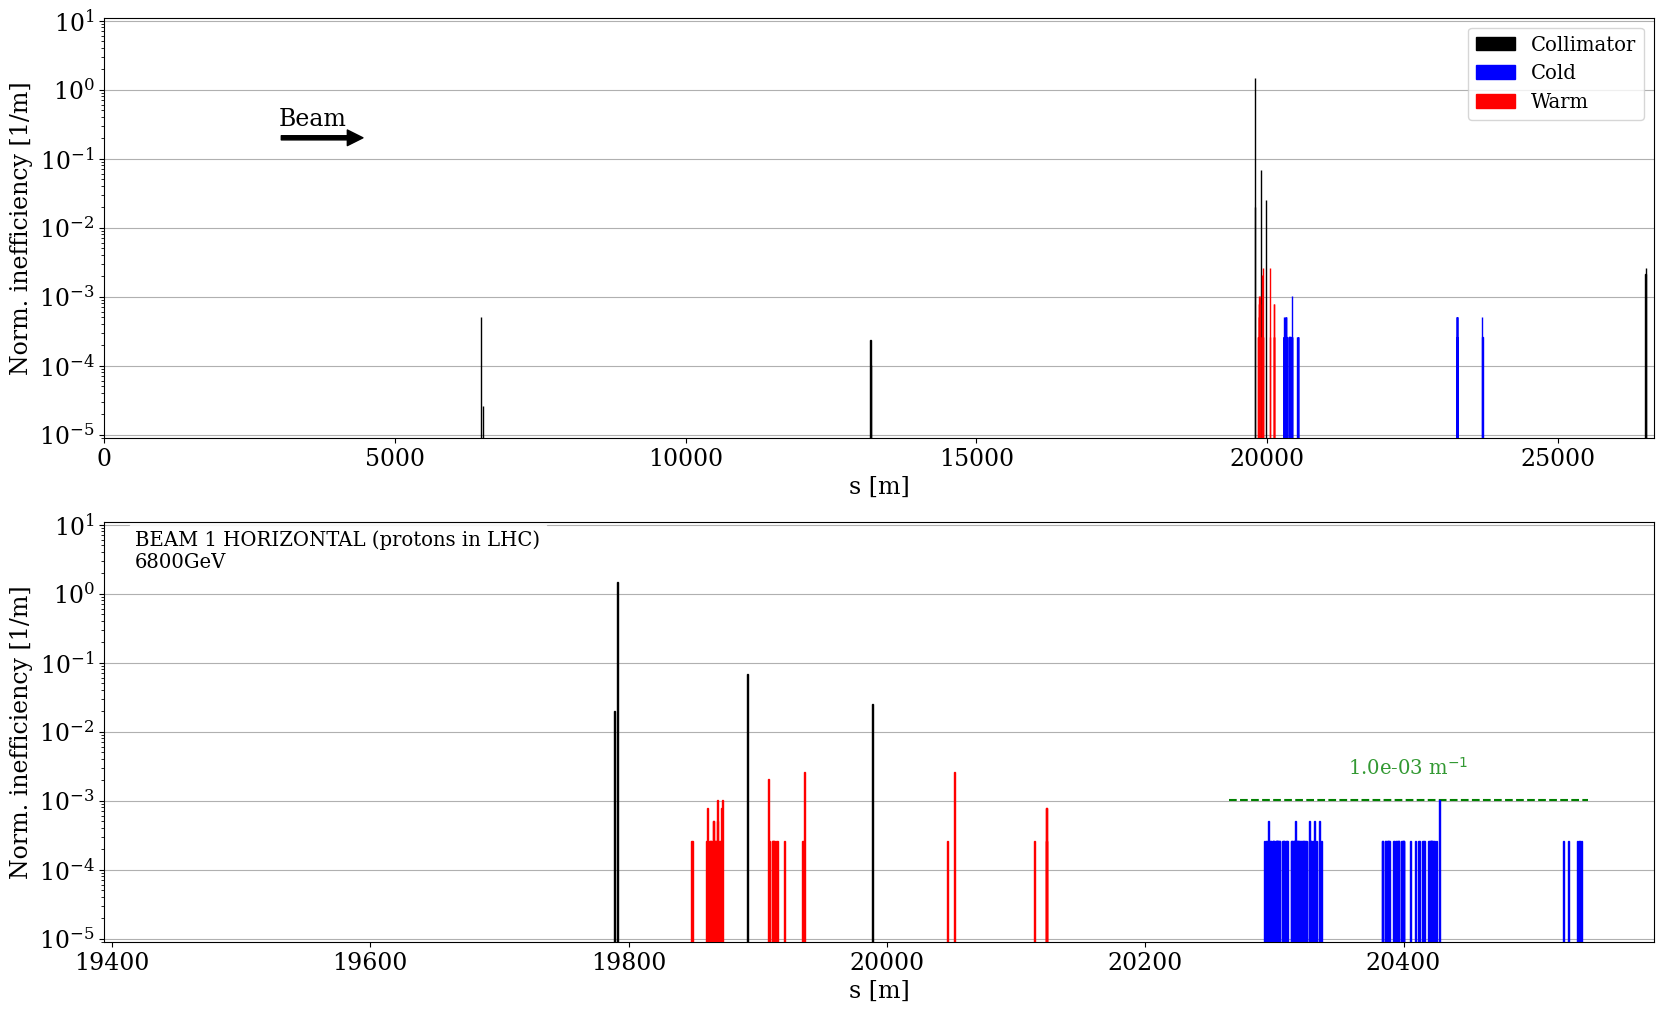

In [12]:
# Plot the loss map
_ = lm.plot_lossmap(lmap)